<a href="https://colab.research.google.com/github/Nick-Azzarano/Machine-Learning-Practice/blob/main/Spring2025/Final_Project/Azzarano_Nick_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nick Azzarano
<br/>
CSCI 335
<br/>
Anton Selitskiy
<br/>
May 7, 2025

# CSCI-335 Final Project: Project 1 Fine-Tuning

In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.io import read_image
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

In [ ]:
# Need to upload public_tests.zip each time you use this notebook
!unzip public_tests.zip

Streaming output truncated to the last 5000 lines.
  inflating: 00_test_img_input/test/images/0672.jpg  
  inflating: 00_test_img_input/test/images/2085.jpg  
  inflating: 00_test_img_input/test/images/0106.jpg  
  inflating: 00_test_img_input/test/images/1056.jpg  
  inflating: 00_test_img_input/test/images/1159.jpg  
  inflating: 00_test_img_input/test/images/0256.jpg  
  inflating: 00_test_img_input/test/images/2269.jpg  
  inflating: 00_test_img_input/test/images/0664.jpg  
  inflating: 00_test_img_input/test/images/1981.jpg  
  inflating: 00_test_img_input/test/images/0929.jpg  
  inflating: 00_test_img_input/test/images/1888.jpg  
  inflating: 00_test_img_input/test/images/0957.jpg  
  inflating: 00_test_img_input/test/images/0389.jpg  
  inflating: 00_test_img_input/test/images/0323.jpg  
  inflating: 00_test_img_input/test/images/0717.jpg  
  inflating: 00_test_img_input/test/images/0186.jpg  
  inflating: 00_test_img_input/test/images/0468.jpg  
  inflating: 00_test_img_input/

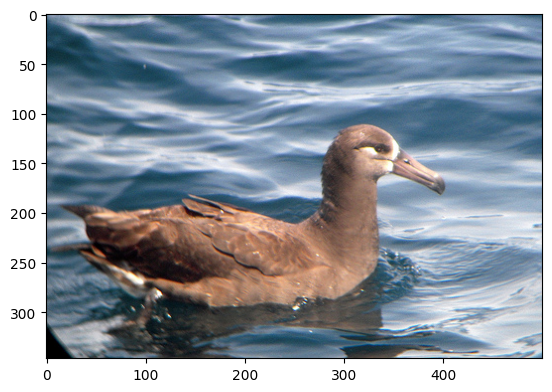

In [ ]:
im = read_image('/content/00_test_img_input/test/images/0005.jpg')
plt.imshow(im.permute(1, 2, 0))

In [ ]:
im.shape

In [ ]:
class My_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.path_to_data = root_dir
        self.transform = transform
        self.class_to_idx = {label: idx for idx, label in enumerate(sorted(self.annotations['class_id'].unique()))}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.data.iloc[index]['filename'] # Get the image path from the .csv
        label = self.data.iloc[index]['class_id'] # Get the corresponding label from the .csv
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torch.utils.data import Subset

In [ ]:
# Transform for training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [ ]:
# Transform for validation
transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [ ]:
csv_file = '/content/00_test_img_input/train/gt.csv'
root_dir = '/content/00_test_img_input/train/images'

In [ ]:
dataset = My_Dataset(csv_file=csv_file, root_dir=root_dir, transform=transform_train)

In [ ]:
# 80% Training, 20% Validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [ ]:
# Randomly split the dataset into training and validation sets
train_indices, val_indices = random_split(range(len(dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))

In [ ]:
# Create subsets for the data
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

In [ ]:
# Apply the transforms to the datasets
train_dataset = BirdDataset(csv_file=csv_file, image_dir=image_dir, transform=transform_train)
val_dataset = BirdDataset(csv_file=csv_file, image_dir=image_dir, transform=transform_val)

In [ ]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
# Create model
model = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 220MB/s]


In [ ]:
# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Unfreeze the last few layers to tune them
for param in model.features[-3:].parameters():
    param.requires_grad = True

In [ ]:
# There are 50 types of birds in the given dataset
num_classes = 50

Classes: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6, np.int64(7): 7, np.int64(8): 8, np.int64(9): 9, np.int64(10): 10, np.int64(11): 11, np.int64(12): 12, np.int64(13): 13, np.int64(14): 14, np.int64(15): 15, np.int64(16): 16, np.int64(17): 17, np.int64(18): 18, np.int64(19): 19, np.int64(20): 20, np.int64(21): 21, np.int64(22): 22, np.int64(23): 23, np.int64(24): 24, np.int64(25): 25, np.int64(26): 26, np.int64(27): 27, np.int64(28): 28, np.int64(29): 29, np.int64(30): 30, np.int64(31): 31, np.int64(32): 32, np.int64(33): 33, np.int64(34): 34, np.int64(35): 35, np.int64(36): 36, np.int64(37): 37, np.int64(38): 38, np.int64(39): 39, np.int64(40): 40, np.int64(41): 41, np.int64(42): 42, np.int64(43): 43, np.int64(44): 44, np.int64(45): 45, np.int64(46): 46, np.int64(47): 47, np.int64(48): 48, np.int64(49): 49}
Number of classes: 50


Model

In [ ]:
# Replace the classifier to match the number of classes
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

In [ ]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
# Evaluation function
def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    topk_correct = [0] * min(5, num_classes)  # Match top-k to class count
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            k = min(5, outputs.size(1))  # Ensure k <= number of classes
            _, preds = outputs.topk(k, dim=1, largest=True, sorted=True)
            total += labels.size(0)
            correct += (preds[:, 0] == labels).sum().item()
            for i in range(k):
                topk_correct[i] += (preds[:, i] == labels).sum().item()
    acc = 100 * correct / total
    topk_acc = [100 * k / total for k in topk_correct]
    return acc, topk_acc


In [ ]:
import csv

In [ ]:
from tqdm import tqdm

# Training loop
num_epochs = 15
best_acc = 0.0

# Create CSV file and header
log_path = "training_log.csv"
with open(log_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Val Acc', 'Top-5 Acc'])

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for step, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    # Evaluate after epoch
    val_acc, topk_acc = evaluate(model, val_loader)
    avg_loss = running_loss / len(train_loader)

    # Save accuracy results to separate .csv file
    with open(log_path, mode='a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([epoch+1, avg_loss, val_acc, topk_acc])

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}%")
    print(f"  Top-5 Accuracy: {topk_acc}")

    # Only save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'birds_model.pt')
        print(f"Saved model with val_acc = {val_acc:.4f}")

NameError: name 'csv' is not defined